<center><b><font size=6>Data Exploration and Pre-processing<b><center>

This notebook performs the following tasks for analyzing attack data.

0. **Install Dependencies**
1. **Dataset Preparation**
2. **Temporal Analysis** 
3. **Session Analysis**
4. **Intent Distribution**
5. **Text Representation**
6. **Error Reporting** 

<center><b><font size=5>Install Dependencies<b><center>

In [1]:
!python ../scripts/install_dependencies.py section1

Installing common packages: pandas, pyarrow
Installing Section 1 packages: numpy, matplotlib, seaborn, scikit-learn, wordcloud
                                              0.0/299.9 kB ? eta -:--:--
     -----                                 41.0/299.9 kB 991.0 kB/s eta 0:00:01
     ----------------------------           225.3/299.9 kB 2.8 MB/s eta 0:00:01
     -------------------------------------- 299.9/299.9 kB 2.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
from collections import Counter 
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from wordcloud import WordCloud
import matplotlib.dates
import os
import sys
sys.path.append("../")
from scripts.data_processing import sampling, split_train_test
from scripts.data_storage_utils import save_plot

In [3]:
# Global variables
global_overwrite = True
plot_directory = "../results/figures/plots/section1"

<center><b><font size=5>Dataset Preparation<b><center>


- Load the dataset (`ssh_attacks.parquet`) into a Pandas DataFrame.

In [4]:
SSH_Attacks = pd.read_parquet("../data/processed/ssh_attacks_decoded.parquet")

In [5]:
SSH_Attacks

,session_id,full_session,first_timestamp,Set_Fingerprint
0,0,"[enable, system, shell, sh, cat, /proc/mounts,...",2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]"
1,1,"[enable, system, shell, sh, cat, /proc/mounts,...",2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]"
2,2,"[enable, system, shell, sh, cat, /proc/mounts,...",2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]"
3,3,"[enable, system, shell, sh, cat, /proc/mounts,...",2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]"
4,4,"[enable, system, shell, sh, cat, /proc/mounts,...",2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]"
...,...,...,...,...
233030,233042,"[cat, /proc/cpuinfo, grep, name, wc, -l, echo,...",2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]"
233031,233043,"[cat, /proc/cpuinfo, grep, name, wc, -l, echo,...",2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]"
233032,233044,"[cat, /proc/cpuinfo, grep, name, wc, -l, echo,...",2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]"
233033,233045,"[cat, /proc/cpuinfo, grep, name, wc, -l, echo,...",2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]"


In [6]:
all_words = SSH_Attacks["full_session"].explode().unique()
all_words

array(['enable', 'system', 'shell', ...,
       'Pw0rdnoKjeZWZ9trC1noKjeZWZ9trC1n',
       'qwe1234nCSD0bTyzOkJNnCSD0bTyzOkJN',
       'qwe1234nCSD0bTyzOkJNnCSD0bTyzOkJNn'], dtype=object)

- Inspect the dataset schema: check for missing values, anomalies, or inconsistencies.

In [7]:
# 1. Inspect the basic structure (columns and data types)
print("Dataset Structure:")
print(SSH_Attacks.info())

# 2. Check for missing values
print("\nMissing Values:")
print(SSH_Attacks.isnull().sum())  # Display the number of missing values per column

# 3. Check for duplicates
print("\nDuplicate Rows:")

Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233035 entries, 0 to 233034
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   session_id       233035 non-null  int64              
 1   full_session     233035 non-null  object             
 2   first_timestamp  233035 non-null  datetime64[ns, UTC]
 3   Set_Fingerprint  233035 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 7.1+ MB
None

Missing Values:
session_id         0
full_session       0
first_timestamp    0
Set_Fingerprint    0
dtype: int64

Duplicate Rows:


In [8]:
# If the column already contains lists, apply explode directly
all_classes = SSH_Attacks['Set_Fingerprint'].explode().str.strip()

# Now, count the occurrences of each class
class_counts = all_classes.value_counts()

print(class_counts)

Set_Fingerprint
Discovery          232145
Persistence        211295
Execution           92927
Defense Evasion     18999
Harmless             2206
Other                 327
Impact                 27
Name: count, dtype: int64


Overwriting file: '../results/figures/plots/section1\distribution_of_classes.png'


C:\Users\abhij\AppData\Local\Temp\ipykernel_6584\2340372650.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


Plot saved successfully at: '../results/figures/plots/section1\distribution_of_classes.png'


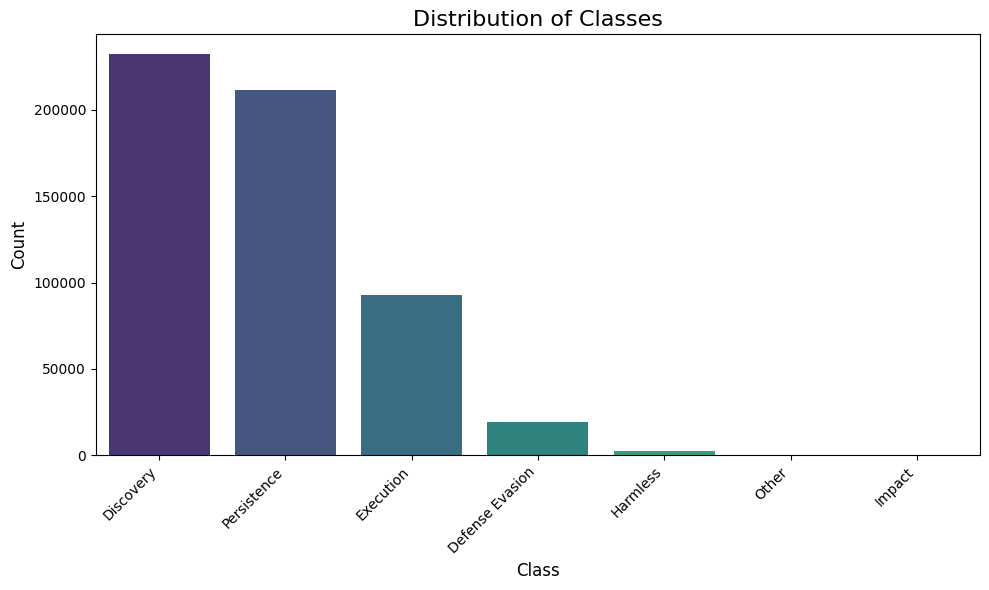

In [9]:
plt.figure(figsize=(10, 6))

# Create the bar plot
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

# Add labels and title
plt.title('Distribution of Classes', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "distribution_of_classes", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()

<center><b><font size=5>Temporal Analysis<b><center>

When are the attacks performed? Analyze the temporal series.
- Convert `first_timestamp` to a datetime format.

In [10]:
# Ensure the first_timestamp column is in datetime format
SSH_Attacks['first_timestamp'] = pd.to_datetime(SSH_Attacks['first_timestamp'])

- Analyze attack frequencies over time: hourly, daily, monthly trends.

Overwriting file: '../results/figures/plots/section1\temporal_series_of_ssh_attacks.png'
Plot saved successfully at: '../results/figures/plots/section1\temporal_series_of_ssh_attacks.png'


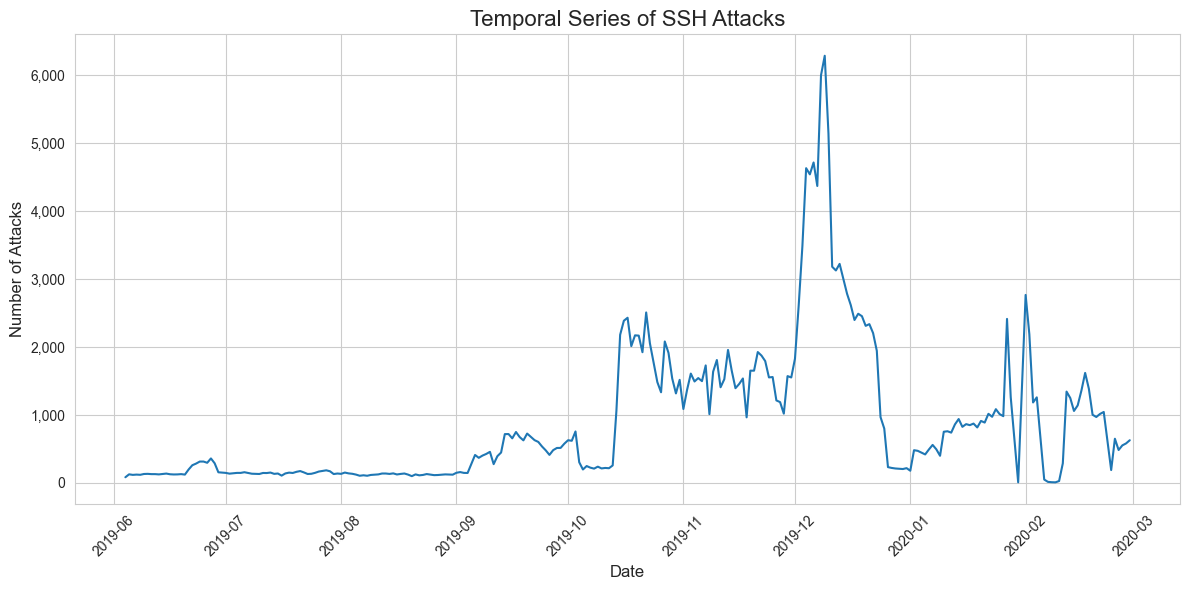

In [11]:
# Aggregate data by date
temporal_series = (
    SSH_Attacks.groupby(SSH_Attacks['first_timestamp'].dt.date)
    .size()
    .reset_index(name='attack_count')
)

# Rename columns for clarity
temporal_series.rename(columns={'first_timestamp': 'date'}, inplace=True)

# Define a formatter for the y-axis
def thousands_formatter(x, _):
    return f"{int(x):,}"

# Plot the data
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=temporal_series, x='date', y='attack_count')

# Improve x and y-axis formatting
plt.title('Temporal Series of SSH Attacks', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "temporal_series_of_ssh_attacks", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()

Evaluation of the attacks per hour:

Overwriting file: '../results/figures/plots/section1\attack_frequency_by_hour.png'
Plot saved successfully at: '../results/figures/plots/section1\attack_frequency_by_hour.png'


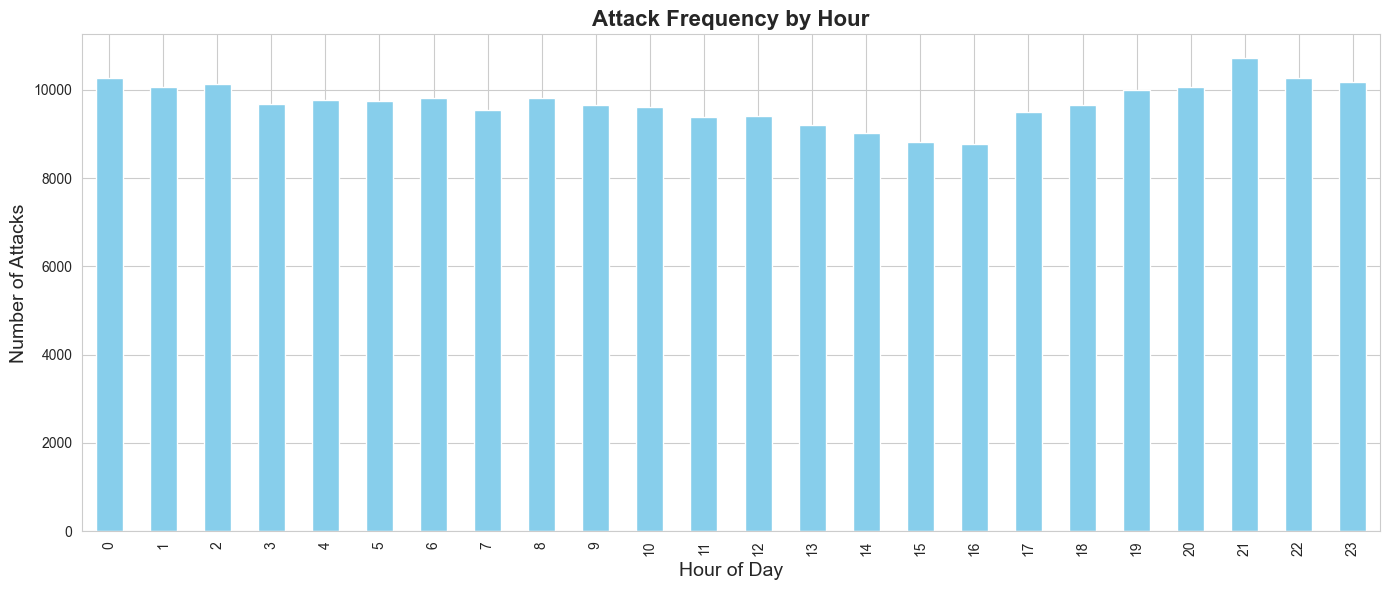

In [12]:
# Analyze attack frequencies over time: hourly, daily, monthly trends
SSH_Attacks['hour'] = SSH_Attacks['first_timestamp'].dt.hour

# Plot time-series graphs for attack distributions
plt.figure(figsize=(14, 6))
SSH_Attacks['hour'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Attack Frequency by Hour', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Number of Attacks', fontsize=14)

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "attack_frequency_by_hour", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()

Evaluation of the attacks per month:

Overwriting file: '../results/figures/plots/section1\attack_frequency_by_month.png'
Plot saved successfully at: '../results/figures/plots/section1\attack_frequency_by_month.png'


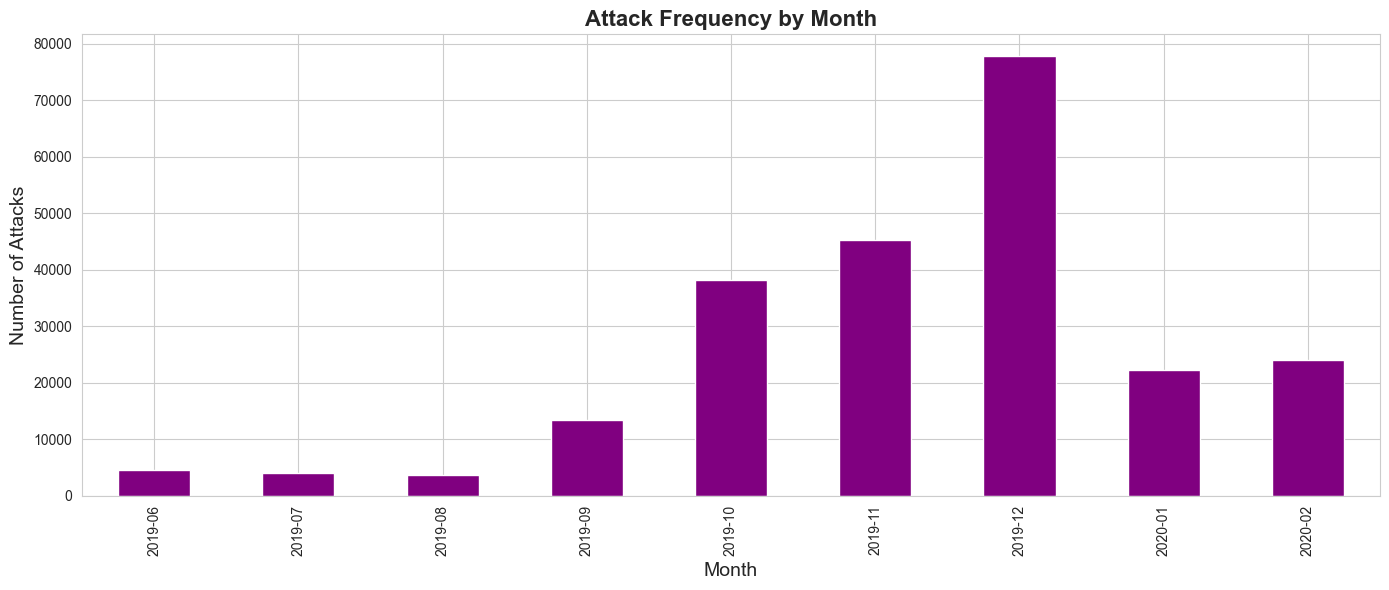

In [13]:
SSH_Attacks['first_timestamp'] = SSH_Attacks['first_timestamp'].dt.tz_localize(None)  # Rimuove il fuso orario, altrimenti genera un warning
SSH_Attacks['month'] = SSH_Attacks['first_timestamp'].dt.to_period('M')

plt.figure(figsize=(14, 6))
SSH_Attacks['month'].value_counts().sort_index().plot(kind='bar', color='purple')
plt.title('Attack Frequency by Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Attacks', fontsize=14)

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "attack_frequency_by_month", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()


Evaluation of the attacks per year:

C:\Users\abhij\AppData\Local\Temp\ipykernel_6584\3388496857.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year_counts.index, y=year_counts.values, palette=palette)


Overwriting file: '../results/figures/plots/section1\attack_frequency_by_year.png'
Plot saved successfully at: '../results/figures/plots/section1\attack_frequency_by_year.png'


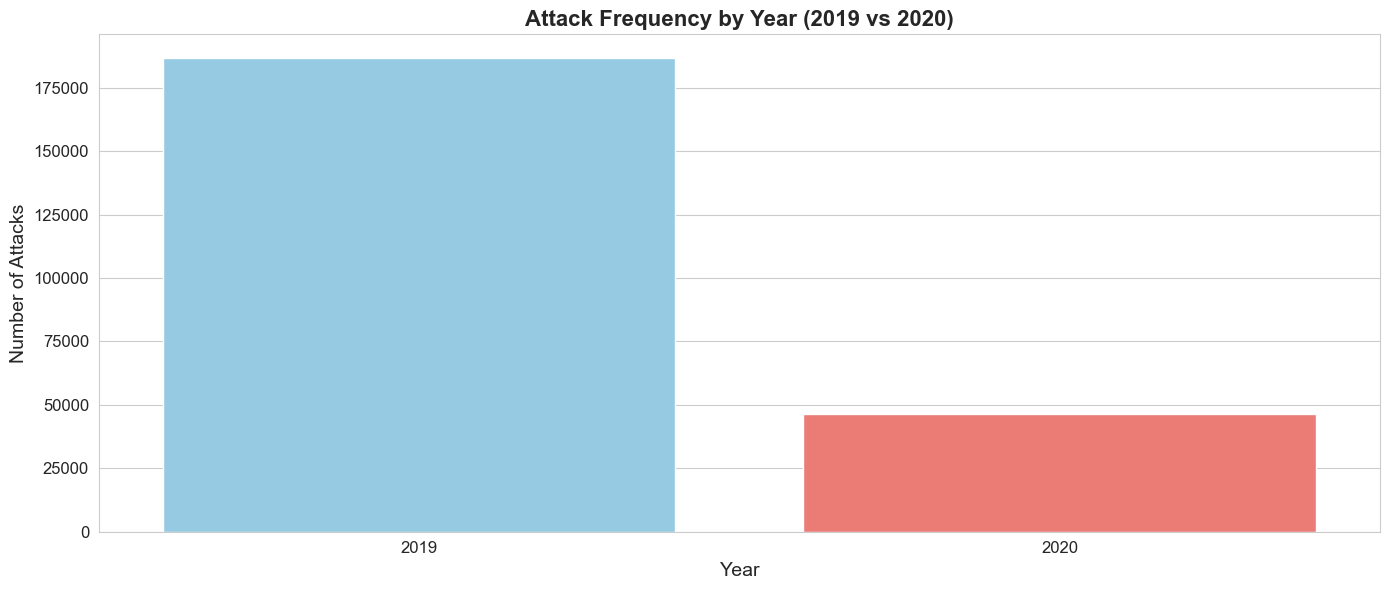

In [14]:
SSH_Attacks['year'] = SSH_Attacks['first_timestamp'].dt.year
# Count the attacks by year and sort by year
year_counts = SSH_Attacks['year'].value_counts().sort_index()

# Define a pastel color palette specifically for the two years
palette = ['#89CFF0', '#FF6961']  # Sky blue for 2019, light red for 2020

# Plot the attack frequency by year with distinct pastel colors
plt.figure(figsize=(14, 6))
sns.barplot(x=year_counts.index, y=year_counts.values, palette=palette)

# Add labels and title
plt.title('Attack Frequency by Year (2019 vs 2020)', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Attacks', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "attack_frequency_by_year", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()


- Plot time-series graphs for attack distributions.

Overwriting file: '../results/figures/plots/section1\combined_temporal_series_of_ssh_attacks_by_type.png'
Plot saved successfully at: '../results/figures/plots/section1\combined_temporal_series_of_ssh_attacks_by_type.png'


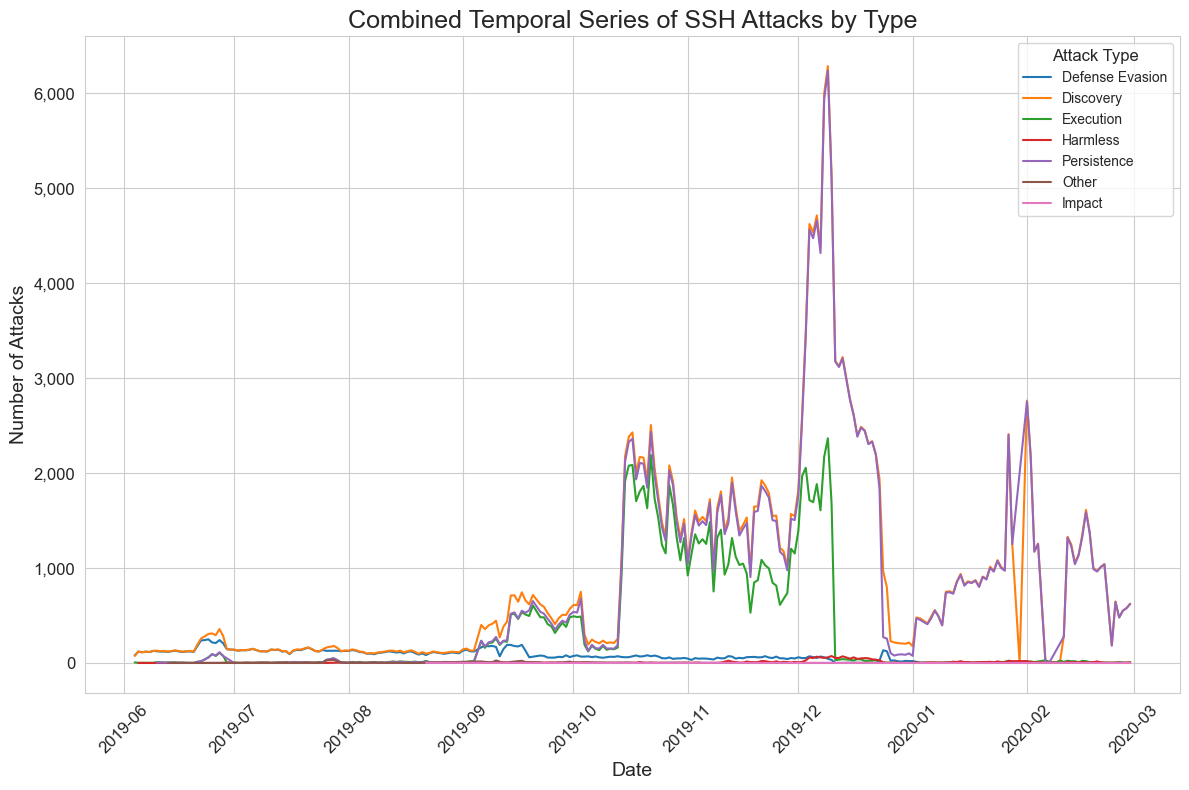

In [15]:
# Ensure the first_timestamp column is in datetime format
SSH_Attacks['first_timestamp'] = pd.to_datetime(SSH_Attacks['first_timestamp'])

# Explode the Set_Fingerprint column to create separate rows for each intent
SSH_Attacks_exploded = SSH_Attacks.explode('Set_Fingerprint')

# Group by Set_Fingerprint and date to count occurrences
grouped_SSH_Attacks = (
    SSH_Attacks_exploded.groupby([SSH_Attacks_exploded['first_timestamp'].dt.date, 'Set_Fingerprint'])
    .size()
    .reset_index(name='attack_count')
)

# Rename columns for clarity
grouped_SSH_Attacks.rename(columns={'first_timestamp': 'date'}, inplace=True)

# Plot a final graph that includes all the attack types
plt.figure(figsize=(12, 8))
unique_fingerprints = grouped_SSH_Attacks['Set_Fingerprint'].unique()
for fingerprint in unique_fingerprints:
    temp_SSH_Attacks = grouped_SSH_Attacks[grouped_SSH_Attacks['Set_Fingerprint'] == fingerprint]
    sns.lineplot(data=temp_SSH_Attacks, x='date', y='attack_count', label=fingerprint)

# Improve x and y-axis formatting
plt.title('Combined Temporal Series of SSH Attacks by Type', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Attacks', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.legend(title='Attack Type', fontsize=10, title_fontsize=12)

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "combined_temporal_series_of_ssh_attacks_by_type", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()

- Extra frequency plot divided by classes.

Overwriting file: '../results/figures/plots/section1\ssh_attacks_by_day_of_the_week_and_attack_class.png'
Plot saved successfully at: '../results/figures/plots/section1\ssh_attacks_by_day_of_the_week_and_attack_class.png'


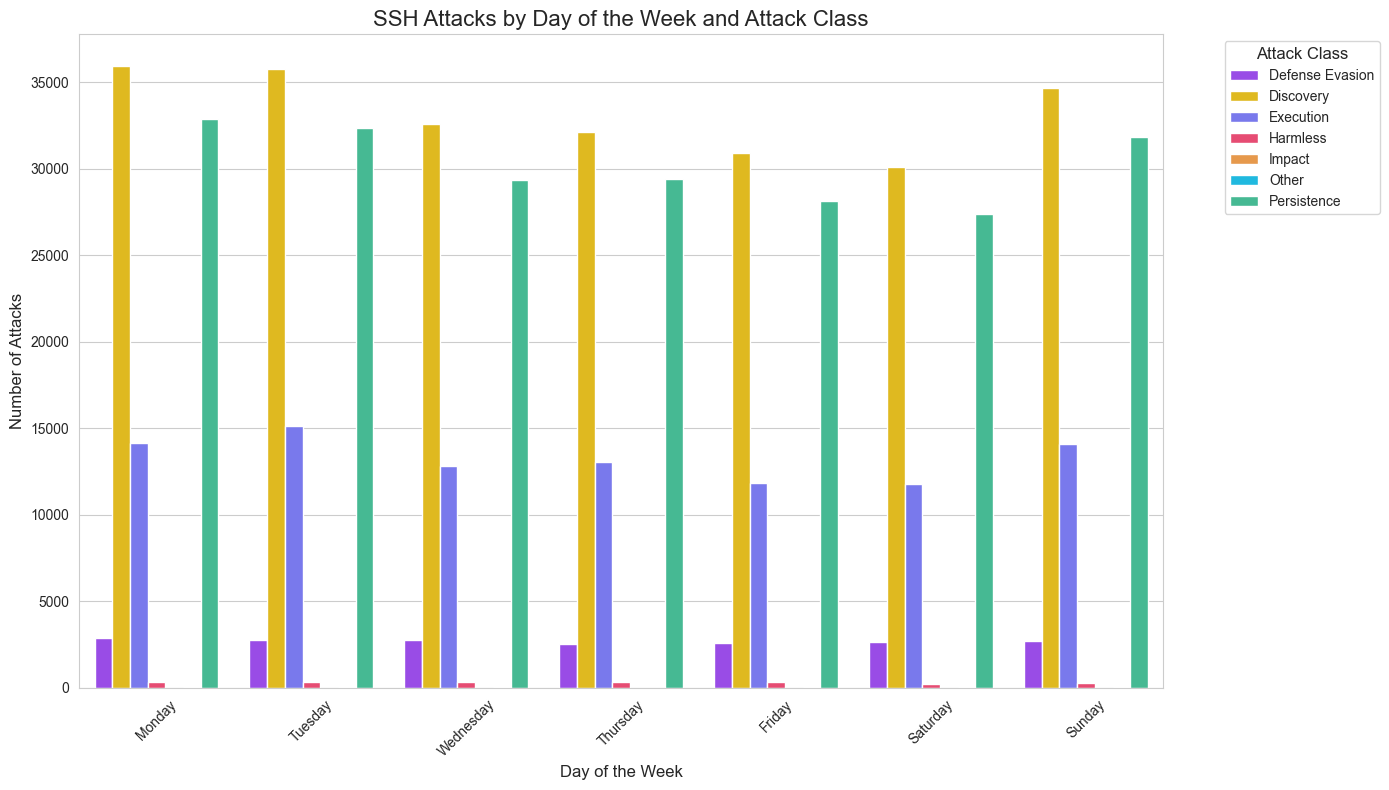

In [16]:
# Ensure the first_timestamp column is in datetime format (if not already)
SSH_Attacks['first_timestamp'] = pd.to_datetime(SSH_Attacks['first_timestamp'])
# Extract the day of the week from the first_timestamp column
SSH_Attacks['day_of_week'] = SSH_Attacks['first_timestamp'].dt.day_name()
# Explode the Set_Fingerprint column to create separate rows for each intent
SSH_Attacks_exploded = SSH_Attacks.explode('Set_Fingerprint')
# Group by day_of_week and Set_Fingerprint, and count the unique occurrences of first_timestamp
attack_counts_by_day_fingerprint = (
    SSH_Attacks_exploded.groupby(['day_of_week', 'Set_Fingerprint'])
    .agg(attack_count=('first_timestamp', 'nunique'))
    .reset_index()
)
# Ensure the days of the week are ordered correctly
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
attack_counts_by_day_fingerprint['day_of_week'] = pd.Categorical(attack_counts_by_day_fingerprint['day_of_week'], categories=ordered_days, ordered=True)
attack_counts_by_day_fingerprint = attack_counts_by_day_fingerprint.sort_values(['day_of_week', 'Set_Fingerprint'])

custom_palette = ['#9933FF','#FFCC00',  '#6666FF', '#FF3366', '#FF9933', '#00CCFF', '#33CC99']


# Plot the histogram with the new color palette
plt.figure(figsize=(14, 8))
sns.barplot(data=attack_counts_by_day_fingerprint, 
            x='day_of_week', 
            y='attack_count', 
            hue='Set_Fingerprint', 
            palette=custom_palette)

# Improve plot aesthetics
plt.title('SSH Attacks by Day of the Week and Attack Class', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Attack Class', fontsize=10, title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "ssh_attacks_by_day_of_the_week_and_attack_class", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()

<center><b><font size=6>Session Analysis<b><center>

- Analyze `full_session`:
        - Count characters per session and plot its distribution.
        - Count words per session and plot its distribution.

Overwriting file: '../results/figures/plots/section1\ecdf_for_characters_and_for_words.png'
Plot saved successfully at: '../results/figures/plots/section1\ecdf_for_characters_and_for_words.png'


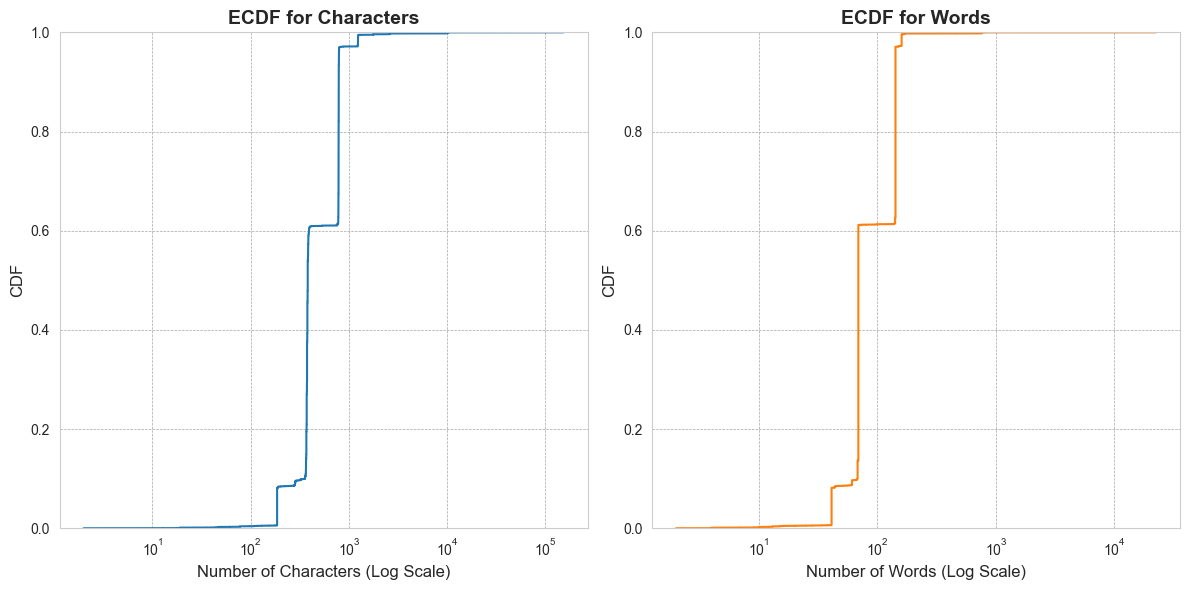

In [17]:
# Calculate the number of characters and words in each session
number_words = SSH_Attacks['full_session'].apply(lambda session: len(session))
number_characters = SSH_Attacks['full_session'].apply(lambda session: sum([len(word) for word in session]))

# Create a DataFrame to store the results
data = {"number_characters": number_characters, "number_words": number_words}
df_number_characters_words = pd.DataFrame(data=data)

# Define a color palette for the plots
palette = ['#1f77b4', '#ff7f0e']  # Blue for characters, orange for words


# Add a minimum value to avoid log10(0)  (Warning)
df_number_characters_words['number_characters'] += 1
df_number_characters_words['number_words'] += 1

plt.figure(figsize=(12, 6))

# ECDF for number of characters
plt.subplot(1, 2, 1)
sns.ecdfplot(
    data=df_number_characters_words['number_characters'],
    log_scale=True,
    color=palette[0]
)
plt.title("ECDF for Characters", fontsize=14, fontweight='bold')
plt.xlabel("Number of Characters (Log Scale)", fontsize=12)
plt.ylabel("CDF", fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# ECDF for number of words
plt.subplot(1, 2, 2)
sns.ecdfplot(
    data=df_number_characters_words['number_words'],
    log_scale=True,
    color=palette[1]
)
plt.title("ECDF for Words", fontsize=14, fontweight='bold')
plt.xlabel("Number of Words (Log Scale)", fontsize=12)
plt.ylabel("CDF", fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "ecdf_for_characters_and_for_words", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()

Overwriting file: '../results/figures/plots/section1\distribution_of_number_of_words_per_session_limited.png'
Plot saved successfully at: '../results/figures/plots/section1\distribution_of_number_of_words_per_session_limited.png'


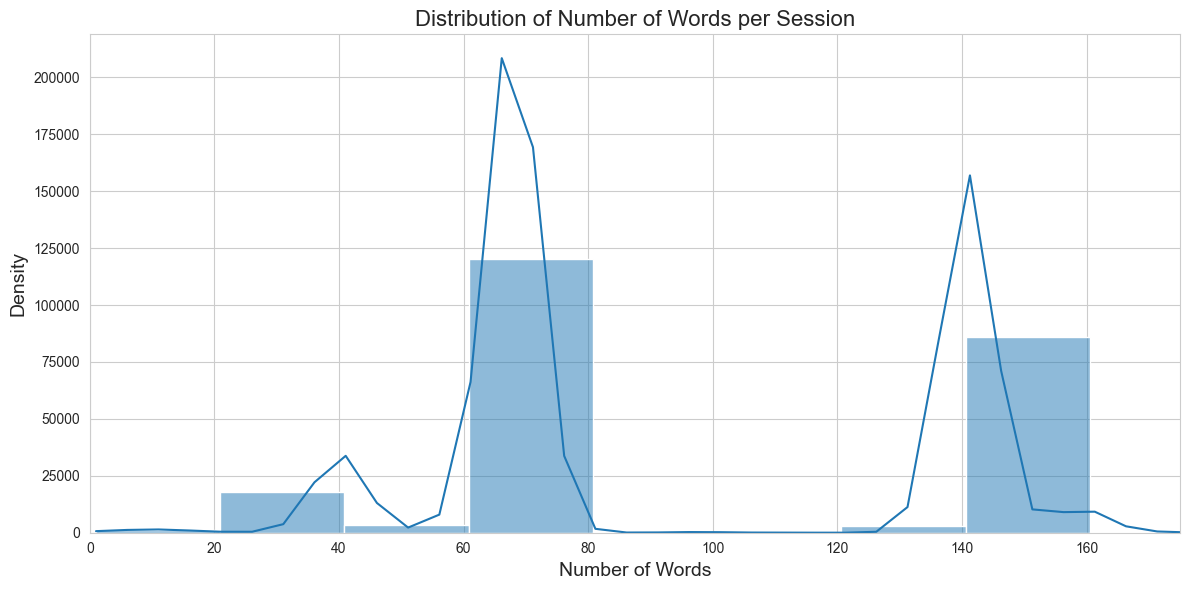

In [18]:
SSH_Attacks['num_words'] = SSH_Attacks['full_session'].apply(lambda x: len(' '.join(x).split()) if isinstance(x, list) else len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.histplot(SSH_Attacks['num_words'], kde=True, bins=50)
plt.title('Distribution of Number of Words per Session', fontsize=16)
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Adjust the x-axis range
plt.xlim(0, 175)

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "distribution_of_number_of_words_per_session_limited", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()

- Extract the most common words using tokenization.
- Create visualizations: bar plots for word frequencies and word clouds.

C:\Users\abhij\AppData\Local\Temp\ipykernel_6584\562701424.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_counts_df, x='Word', y='Frequency', palette=palette)


Overwriting file: '../results/figures/plots/section1\top_10_most_common_words.png'
Plot saved successfully at: '../results/figures/plots/section1\top_10_most_common_words.png'


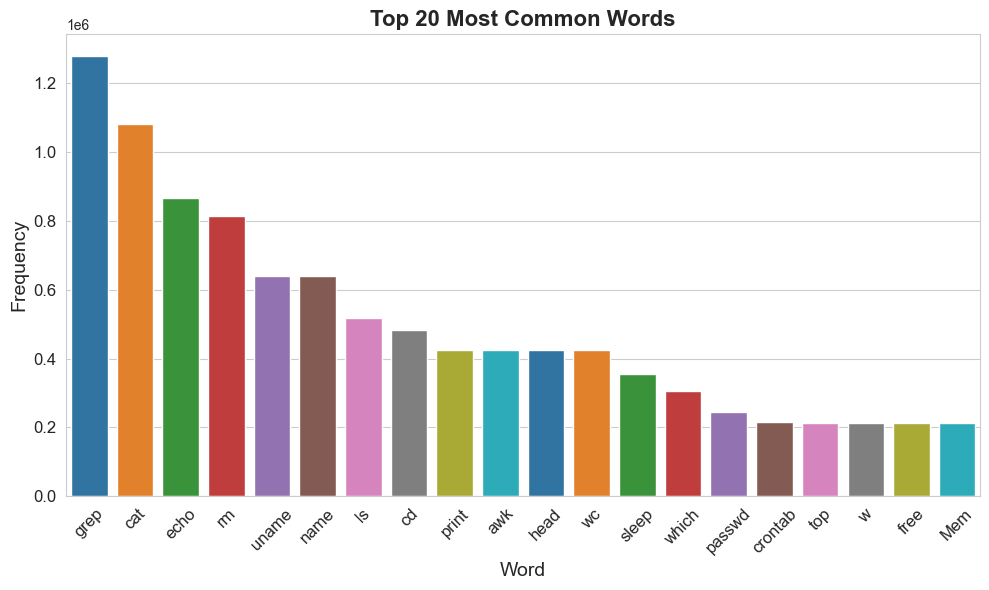

In [19]:
# Extract the most common words using tokenization
all_words = ' '.join([' '.join(map(str, x)) if isinstance(x, (list, np.ndarray)) else str(x) for x in SSH_Attacks['full_session']])
all_words_cleaned = [word for word in all_words.split() if word.isalnum()]
word_counts = pd.Series(all_words_cleaned).value_counts().head(20)

# Convert the word counts to a DataFrame for easier plotting
word_counts_df = word_counts.reset_index()
word_counts_df.columns = ['Word', 'Frequency']

# Define a custom pastel color palette
palette = sns.color_palette("tab10", n_colors=20)

# Create the Seaborn bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=word_counts_df, x='Word', y='Frequency', palette=palette)

# Add titles and labels
plt.title('Top 20 Most Common Words', fontsize=16, fontweight='bold')
plt.xlabel('Word', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "top_10_most_common_words", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()

In [20]:
all_words = SSH_Attacks["full_session"].explode().unique()
all_words

array(['enable', 'system', 'shell', ...,
       'Pw0rdnoKjeZWZ9trC1noKjeZWZ9trC1n',
       'qwe1234nCSD0bTyzOkJNnCSD0bTyzOkJN',
       'qwe1234nCSD0bTyzOkJNnCSD0bTyzOkJNn'], dtype=object)

Overwriting file: '../results/figures/plots/section1\word_cloud_of_most_common_words.png'
Plot saved successfully at: '../results/figures/plots/section1\word_cloud_of_most_common_words.png'


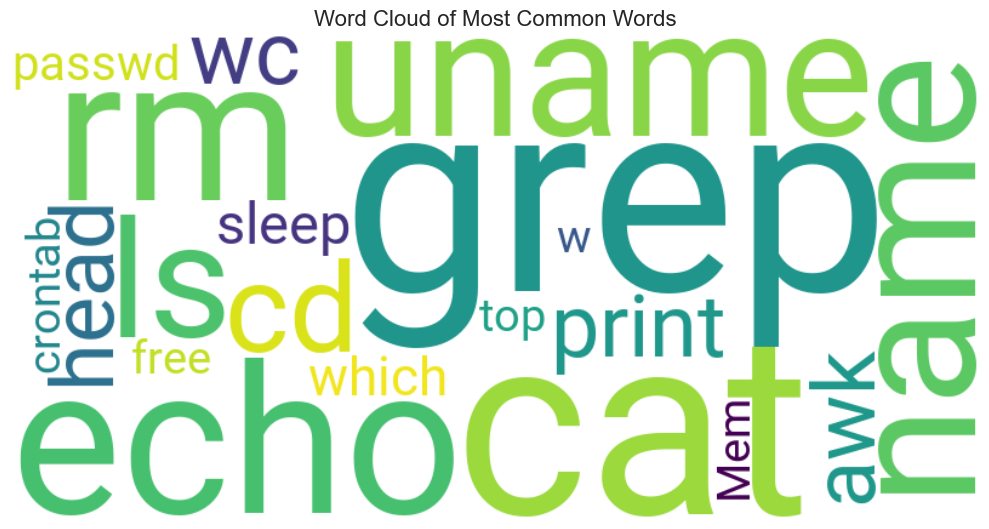

In [21]:
# Path relativo al font nella cartella fonts
font_path = "../resources/Fonts/Roboto-Regular.ttf" 

wordcloud = WordCloud(width=800, height=400, max_words=20, background_color='white', font_path=font_path).generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words', fontsize=16)

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "word_cloud_of_most_common_words", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()

<center><b><font size=6>Intents distribution<b><center>

- Explore the `Set_Fingerprint` column:
    - Count the occurrences of each intent.
    - Analyze the co-occurrence of intents per session.
    - Visualize with bar plots and co-occurrence heatmaps.

In [22]:
def extract_intents(entry):
    if isinstance(entry, np.ndarray):
        return entry.tolist()  # Convert numpy array to list
    elif isinstance(entry, list):
        return entry
    else:
        return []

C:\Users\abhij\AppData\Local\Temp\ipykernel_6584\2797875376.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


Overwriting file: '../results/figures/plots/section1\occurrences_of_each_intent.png'
Plot saved successfully at: '../results/figures/plots/section1\occurrences_of_each_intent.png'


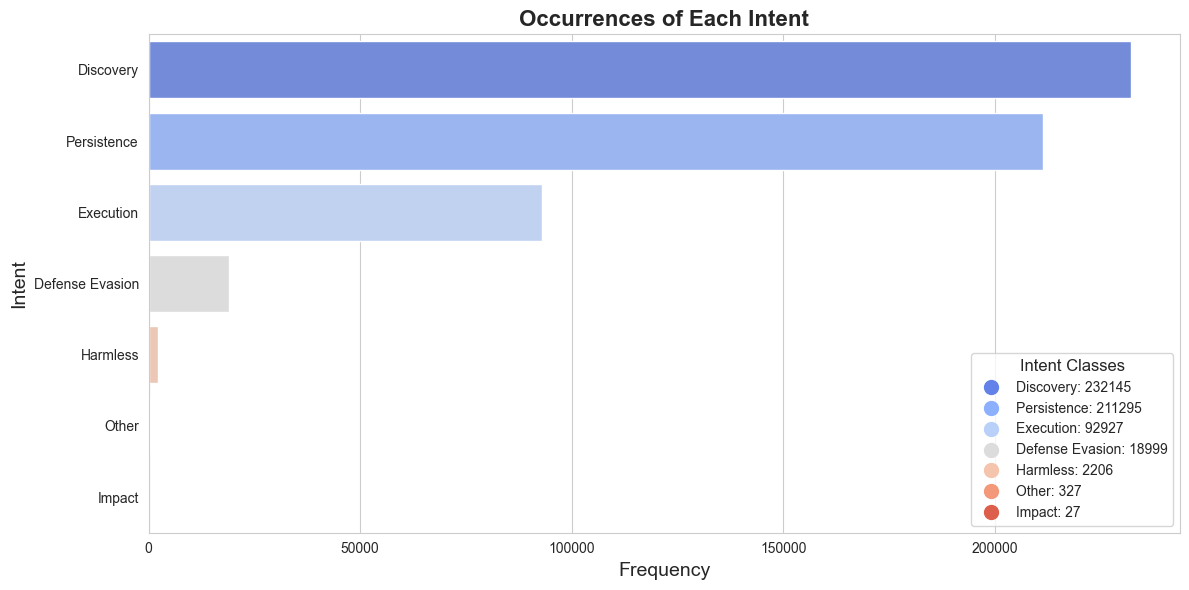

In [23]:
# Apply the extraction function to the Set_Fingerprint column
intents_list = SSH_Attacks['Set_Fingerprint'].apply(extract_intents)
SSH_Attacks['Intents'] = intents_list

# Count the occurrences of each intent
intent_counts = pd.Series(itertools.chain(*intents_list)).value_counts()

# Plot horizontal bar chart
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    y=intent_counts.index, 
    x=intent_counts.values, 
    palette='coolwarm'
)

# Add titles and labels
plt.title('Occurrences of Each Intent', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Intent', fontsize=14)

# Add a legend to the bottom right corner
# Extract the colors from the palette
colors = sns.color_palette('coolwarm', len(intent_counts))
legend_labels = [f"{intent}: {count}" for intent, count in zip(intent_counts.index, intent_counts.values)]
legend_handles = [
    plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=10, linestyle='None') 
    for color, label in zip(colors, legend_labels)
]
plt.legend(
    handles=legend_handles,
    loc='lower right',
    title="Intent Classes",
    fontsize=10,
    title_fontsize=12,
)

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "occurrences_of_each_intent", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()


Overwriting file: '../results/figures/plots/section1\co-occurrence_heatmap_of_intents_in_set_fingerprint_column.png'
Plot saved successfully at: '../results/figures/plots/section1\co-occurrence_heatmap_of_intents_in_set_fingerprint_column.png'


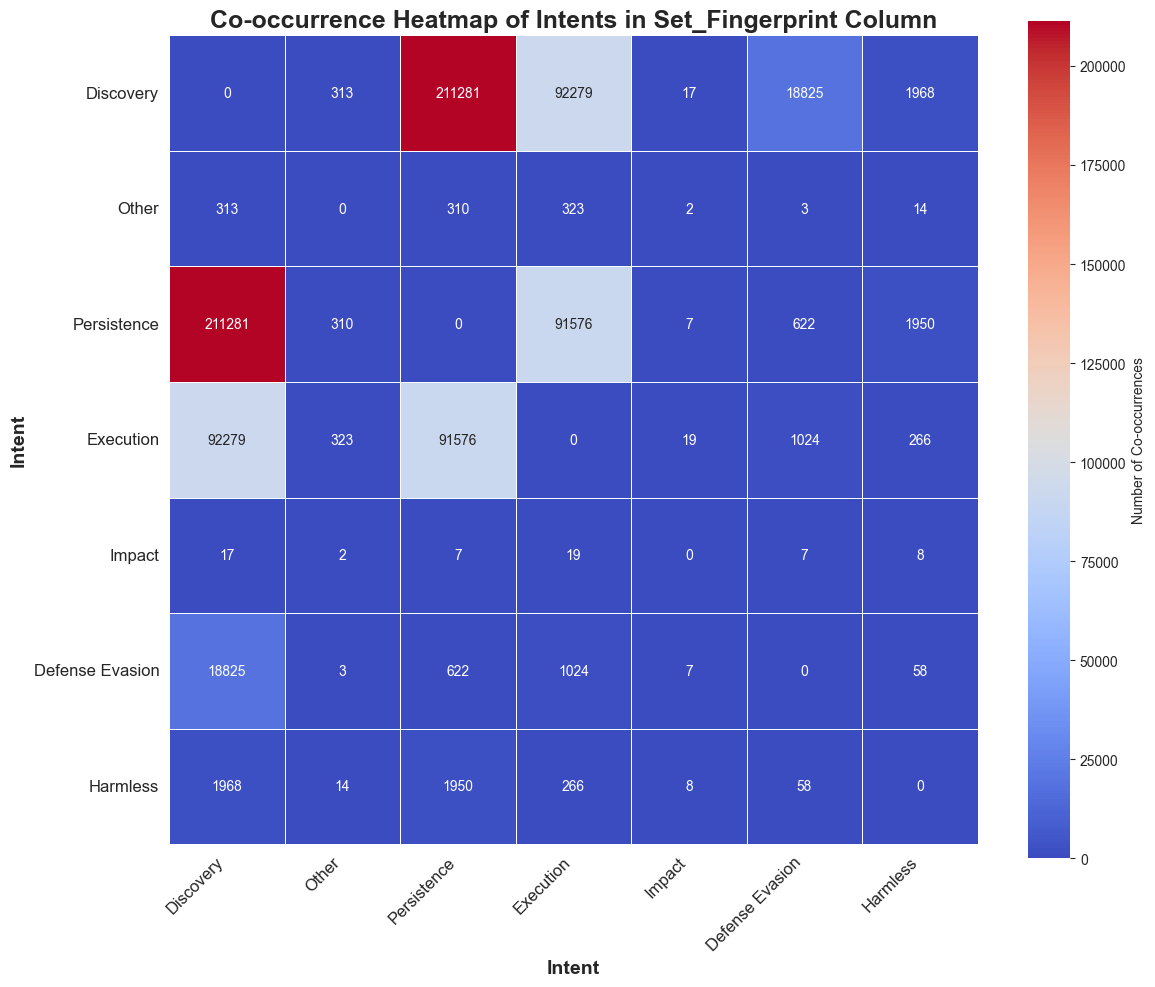

In [24]:
# Create a dictionary to track the rows each intent appears in
intent_to_rows = {}
for idx, intents in enumerate(intents_list):
    if isinstance(intents, list) and len(intents) > 0:
        for intent in intents:
            if intent not in intent_to_rows:
                intent_to_rows[intent] = set()
            intent_to_rows[intent].add(idx)

# Create a set of all unique intents
all_intents = set(intent_to_rows.keys())

# Create a DataFrame that tracks the co-occurrence of intents
co_occurrence_matrix = pd.DataFrame(0, index=list(all_intents), columns=list(all_intents))
for intent1, rows1 in intent_to_rows.items():
    for intent2, rows2 in intent_to_rows.items():
        if intent1 != intent2:
            co_occurrence_count = len(rows1.intersection(rows2))
            co_occurrence_matrix.loc[intent1, intent2] = co_occurrence_count
            
# Plot the co-occurrence heatmap with cleaner formatting
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, annot=True, fmt='.0f', cmap='coolwarm', linewidths=0.5, square=True, cbar_kws={'label': 'Number of Co-occurrences'})
plt.title('Co-occurrence Heatmap of Intents in Set_Fingerprint Column', fontsize=18, fontweight='bold')
plt.xlabel('Intent', fontsize=14, fontweight='bold')
plt.ylabel('Intent', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation=0)

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "co-occurrence_heatmap_of_intents_in_set_fingerprint_column", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()

- Analyze temporal trends for intents (e.g., intent frequency over time).

this is the representation of the single intents over the timestamp

Overwriting file: '../results/figures/plots/section1\intents_over_timestamps.png'
Plot saved successfully at: '../results/figures/plots/section1\intents_over_timestamps.png'


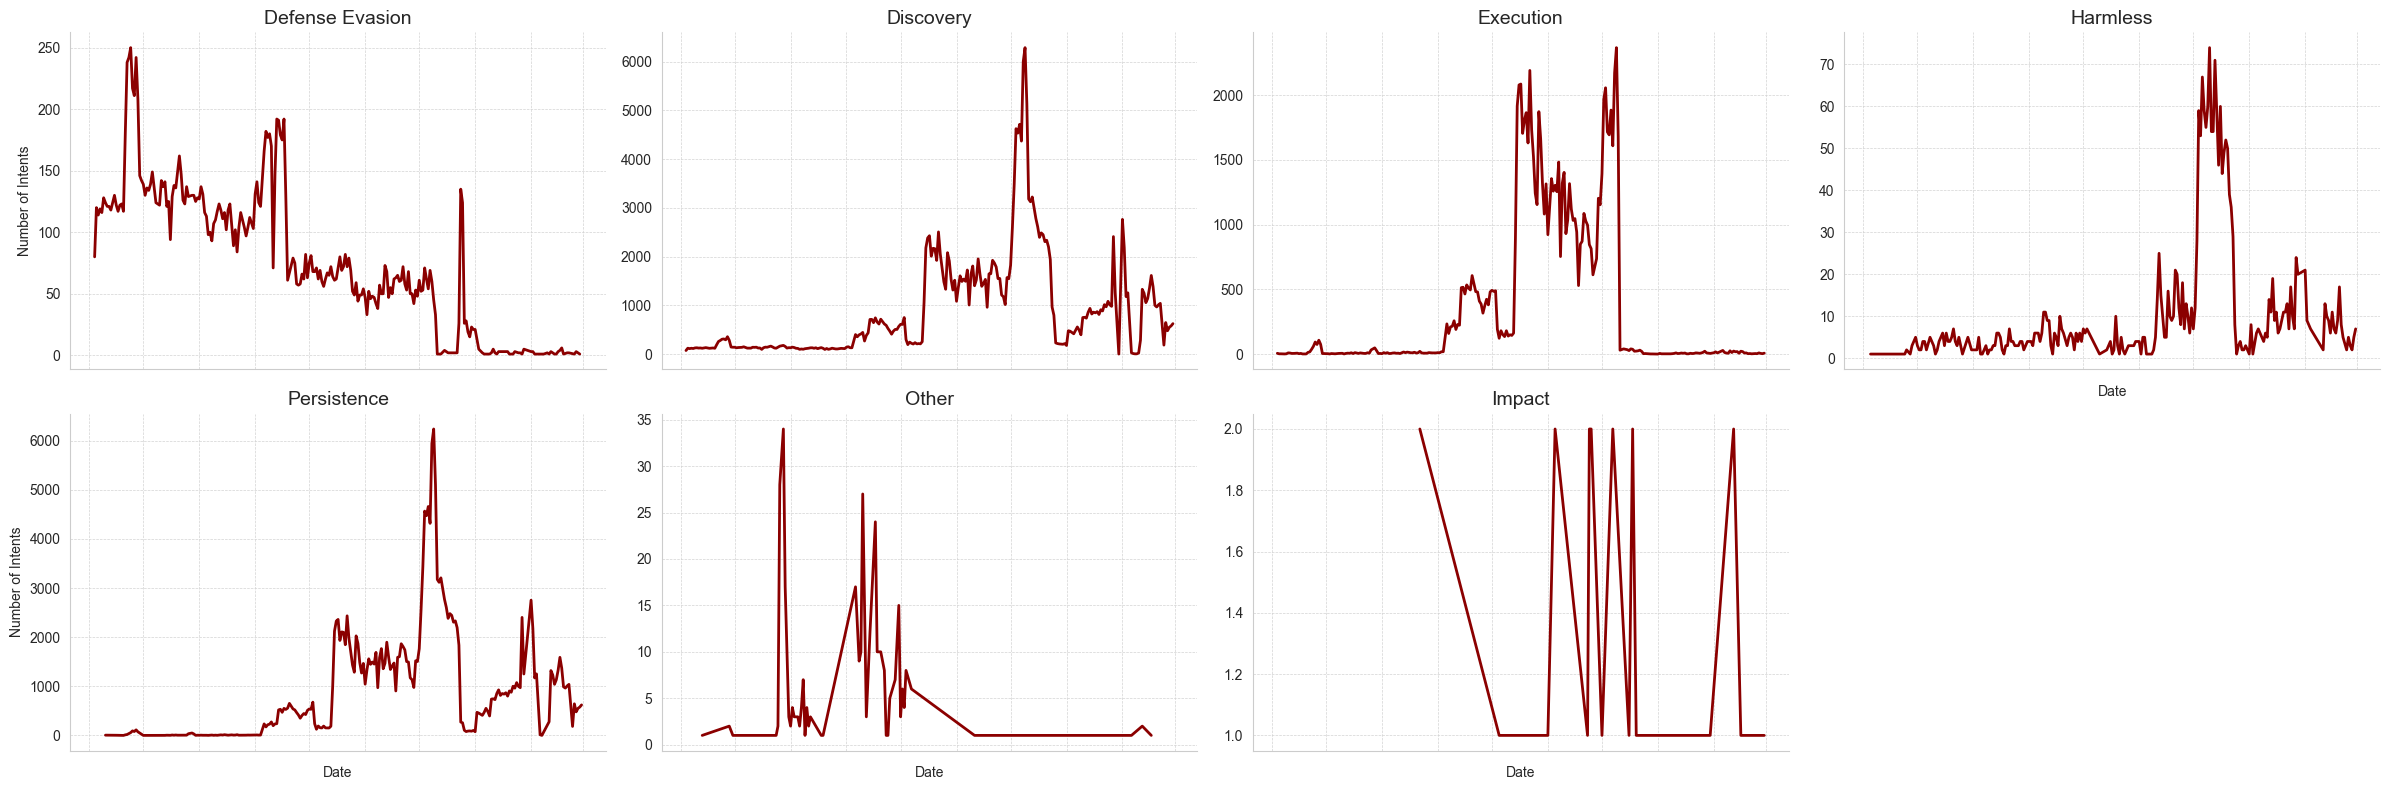

In [25]:
# Assuming Intents and Intents_exploted are already defined and processed
Intents = SSH_Attacks[["session_id", "first_timestamp", "Set_Fingerprint"]]

# Expanding the 'Set_Fingerprint' column to individual intents and sessions
Intents_exploted = Intents.explode('Set_Fingerprint')

# Grouping the data for the plot
Intents_distribution = Intents_exploted.groupby([pd.Grouper(key='first_timestamp', freq='D'), 'Set_Fingerprint']).size().to_frame("Number_of_intents").reset_index()

# Create a FacetGrid with improved design
grid = sns.FacetGrid(Intents_distribution, col="Set_Fingerprint", col_wrap=4, height=4, sharey=False, aspect=1.5)

# Map the lineplot to the grid with customizations
grid.map(sns.lineplot, "first_timestamp", "Number_of_intents", color='darkred', linewidth=2)

# Customize x-axis labels and grid
grid.set_axis_labels("Date", "Number of Intents")
grid.set_titles(col_template="{col_name}", size=14)
grid.set_xticklabels(rotation=45, size=10)

# Add minor gridlines for clarity
for ax in grid.axes.flat:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "intents_over_timestamps", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()

<center><b><font size=6>Text Representation<b><center>

In [26]:
SSH_Attacks = pd.read_parquet("../data/processed/ssh_attacks_decoded.parquet")

- Convert `full_session` to numerical formats:
     - Implement Bag-of-Words (BoW).
     - Compute TF-IDF for each word and associate with sessions.
- Store the preprocessed features for supervised learning.

In [27]:
if not os.path.isfile("../data/processed/BOW_DATASETS/ssh_attacks_bow.parquet"):
    count_vectorizer = CountVectorizer(min_df = 0.01)
    bow = count_vectorizer.fit_transform(SSH_Attacks["full_session"].apply(lambda x : " ".join(x)))
    df_bow = pd.DataFrame(bow.toarray(), index=SSH_Attacks.index, columns = list(sorted(count_vectorizer.vocabulary_.keys())))
    
    for feature in df_bow.columns:
        df_bow[feature] = normalize(df_bow[feature].values.reshape(-1,1), norm="l2", axis=0)
        
    df_bow = pd.concat([SSH_Attacks, df_bow], axis=1)
    ssh_attacks_bow = df_bow.drop(columns=["session_id", "full_session", "first_timestamp"])

    ssh_attacks_bow.to_parquet("../data/processed/BOW_DATASETS/ssh_attacks_bow.parquet")
else:
    ssh_attacks_bow = pd.read_parquet("../data/processed/BOW_DATASETS/ssh_attacks_bow.parquet")

In [28]:
ssh_attacks_bow

,Set_Fingerprint,0kx34uax1rv,15s,172,192,20m,3s,75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw,8m,9p7vd0epz3tz,...,up,var,wc,wget,which,while,x13,x17,x19,xf
0,"[Defense Evasion, Discovery]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000559,0.000000,0.007507,0.0,0.0,0.0,0.0
1,"[Defense Evasion, Discovery]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000559,0.000000,0.007507,0.0,0.0,0.0,0.0
2,"[Defense Evasion, Discovery]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000559,0.000000,0.007507,0.0,0.0,0.0,0.0
3,"[Defense Evasion, Discovery]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000559,0.000000,0.007507,0.0,0.0,0.0,0.0
4,"[Defense Evasion, Discovery]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000559,0.000000,0.007507,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233030,"[Discovery, Persistence]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001042,0.001611,0.002168,0.000000,0.001432,0.000000,0.0,0.0,0.0,0.0
233031,"[Discovery, Persistence]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001042,0.001611,0.002168,0.000000,0.001432,0.000000,0.0,0.0,0.0,0.0
233032,"[Discovery, Persistence]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001042,0.001611,0.002168,0.000000,0.001432,0.000000,0.0,0.0,0.0,0.0
233033,"[Discovery, Persistence]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001042,0.001611,0.002168,0.000000,0.001432,0.000000,0.0,0.0,0.0,0.0


<center><b><font size=6>TF-IDF representation<b><center>

- Document potential misclassified sessions and examples.

In [29]:
if not os.path.isfile("../data/processed/TFIDF_DATASETS/ssh_attacks_tfidf.parquet"):
    tfidf_vectorizer = TfidfVectorizer(min_df = 0.01)
    tfid = tfidf_vectorizer.fit_transform(SSH_Attacks["full_session"].apply(lambda x : " ".join(x)))
    
    df_tfidf = pd.DataFrame(tfid.toarray(), index=SSH_Attacks.index, columns = list(sorted(tfidf_vectorizer.vocabulary_.keys())))
    df_tfidf.head()
    df_tfidf = pd.concat([SSH_Attacks, df_tfidf], axis=1)
    ssh_attacks_tfidf = df_tfidf.drop(columns=["session_id", "full_session", "first_timestamp"])
    ssh_attacks_tfidf.to_parquet("../data/processed/TFIDF_DATASETS/ssh_attacks_tfidf.parquet")
else:
    ssh_attacks_tfidf = pd.read_parquet("../data/processed/TFIDF_DATASETS/ssh_attacks_tfidf.parquet")

In [30]:
ssh_attacks_tfidf

,Set_Fingerprint,0kx34uax1rv,15s,172,192,20m,3s,75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw,8m,9p7vd0epz3tz,...,up,var,wc,wget,which,while,x13,x17,x19,xf
0,"[Defense Evasion, Discovery]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.154131,0.000000,0.156517,0.0,0.0,0.0,0.0
1,"[Defense Evasion, Discovery]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.154131,0.000000,0.156517,0.0,0.0,0.0,0.0
2,"[Defense Evasion, Discovery]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.154131,0.000000,0.156517,0.0,0.0,0.0,0.0
3,"[Defense Evasion, Discovery]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.154131,0.000000,0.156517,0.0,0.0,0.0,0.0
4,"[Defense Evasion, Discovery]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.154131,0.000000,0.156517,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233030,"[Discovery, Persistence]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.067277,0.465673,0.133076,0.000000,0.066583,0.000000,0.0,0.0,0.0,0.0
233031,"[Discovery, Persistence]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.067277,0.465673,0.133076,0.000000,0.066583,0.000000,0.0,0.0,0.0,0.0
233032,"[Discovery, Persistence]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.067277,0.465673,0.133076,0.000000,0.066583,0.000000,0.0,0.0,0.0,0.0
233033,"[Discovery, Persistence]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.067277,0.465673,0.133076,0.000000,0.066583,0.000000,0.0,0.0,0.0,0.0


In [31]:
ssh_attacks_tfidf.columns

Index(['Set_Fingerprint', '0kx34uax1rv', '15s', '172', '192', '20m', '3s',
       '75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw',
       '8m', '9p7vd0epz3tz',
       'aaaab3nzac1yc2eaaaabjqaaaqeardp4cun2lhr4kuhbge7vvacwdli2a8dbnrtorbmz15o73fcbox8nvbut0buanuv9tj2',
       'admin', 'authorizedkeys', 'awk', 'bash', 'bin', 'bs', 'busybox', 'cat',
       'cd', 'chmod', 'chpasswd', 'count', 'cp', 'cpuinfo', 'crontab', 'dd',
       'dev', 'do', 'done', 'dota', 'dota3', 'echo', 'enable', 'exit', 'free',
       'go', 'grep', 'gz', 'head', 'if', 'initall', 'lh', 'ls', 'lscpu',
       'mdrfckr', 'mem', 'mkdir', 'model', 'mountfs', 'mounts', 'mv', 'name',
       'nohup', 'null', 'passwd', 'password', 'print', 'proc', 'read', 'rf',
       'rm', 'root', 'rsa', 'rsync', 'sh', 'shell', 'shm', 'sleep', 'ssh',
